In [8]:

# ===== SVM ADD-ON: self-contained loader + target detection + column typing =====
import os
import numpy as np
import pandas as pd

# -------- 1) Load your dataset into df (edit DATA_PATH) --------
DATA_PATH = r"C:\Users\user\Data-Science-main\mushroom.csv"  # <-- change to your file

def read_csv_any(path, encodings=("utf-8", "cp1252", "latin1")):
    last_err = None
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception as e:
            last_err = e
    raise last_err

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"File not found: {DATA_PATH}")

df = read_csv_any(DATA_PATH)
print("Loaded:", df.shape)
print("Columns:", list(df.columns))

# (optional) standardize column names a bit
df.columns = [c.strip() for c in df.columns]

# -------- 2) Target auto-detection --------
CANDIDATES = ["class", "label", "target", "income", "Outcome", "y"]
TARGET_COL = None
lower_candidates = [x.lower() for x in CANDIDATES]

for c in df.columns:
    if c in CANDIDATES or c.lower() in lower_candidates:
        TARGET_COL = c
        break

if TARGET_COL is None:
    # fallback: pick the last column if it's likely categorical/binary/small-cardinality
    last = df.columns[-1]
    nunq = df[last].nunique(dropna=False)
    if nunq <= max(10, int(0.05 * len(df))):
        TARGET_COL = last
    else:
        raise ValueError(
            "Could not auto-detect target. Set it manually, e.g.: TARGET_COL = 'class'"
        )

print("Using TARGET_COL:", TARGET_COL)

# -------- 3) Column typing for SVM preprocessing --------
# Coerce obvious text columns (excluding target) as categorical
cat_cols = [c for c in df.columns if df[c].dtype == "object" and c != TARGET_COL]
# Numeric columns are those that are numeric and not the target
num_cols = [
    c for c in df.columns
    if c not in cat_cols + [TARGET_COL] and np.issubdtype(df[c].dtype, np.number)
]

# Optional: ensure target is string labels for readability
y = df[TARGET_COL].astype(str)
X = df.drop(columns=[TARGET_COL]).copy()

print(f"\nFinal shapes -> X: {X.shape}, y: {y.shape}")
print("Numeric columns (sample):", num_cols[:10], "..." if len(num_cols) > 10 else "")
print("Categorical columns (sample):", cat_cols[:10], "..." if len(cat_cols) > 10 else "")

# X, y, num_cols, cat_cols, TARGET_COL are now ready for your SVM pipeline



Loaded: (2000, 26)
Columns: ['Unnamed: 0', 'cap_shape', 'cap_surface', 'cap_color', 'bruises', 'odor', 'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 'stalk_shape', 'stalk_root', 'stalk_surface_above_ring', 'stalk_surface_below_ring', 'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type', 'veil_color', 'ring_number', 'ring_type', 'spore_print_color', 'population', 'habitat', 'class', 'stalk_height', 'cap_diameter']
Using TARGET_COL: class

Final shapes -> X: (2000, 25), y: (2000,)
Numeric columns (sample): ['Unnamed: 0', 'stalk_height', 'cap_diameter'] 
Categorical columns (sample): ['cap_shape', 'cap_surface', 'cap_color', 'bruises', 'odor', 'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 'stalk_shape'] ...


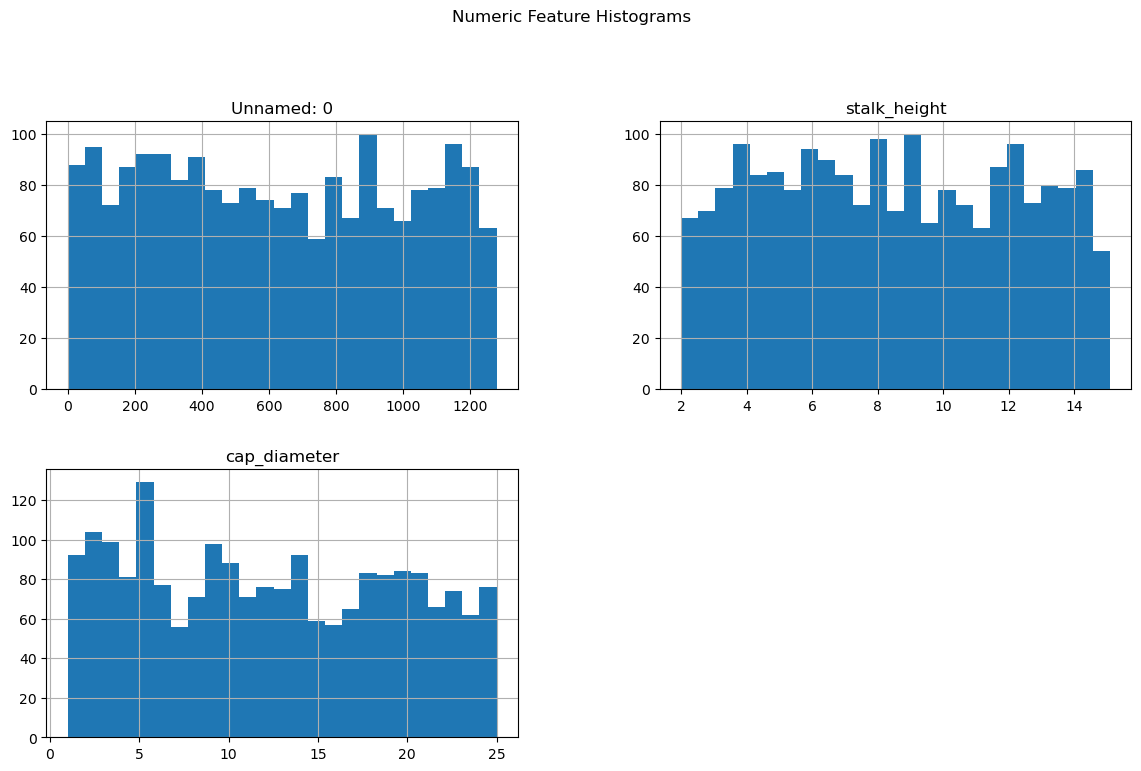

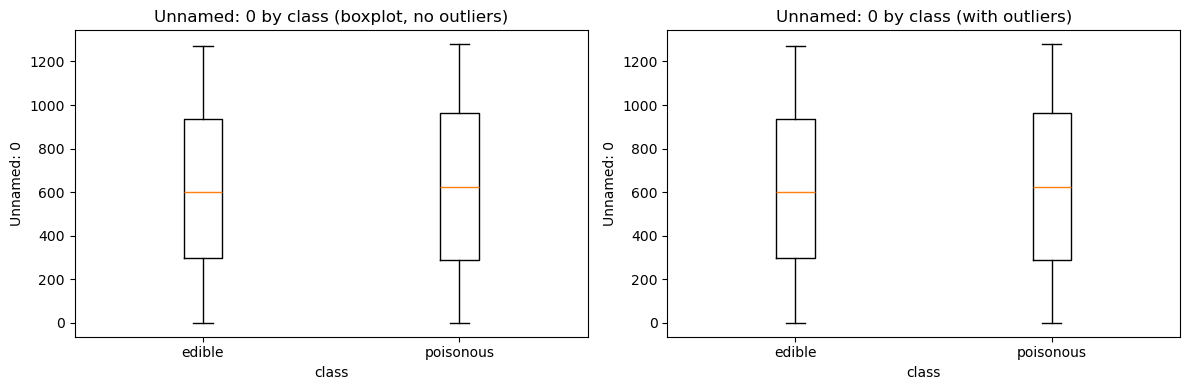

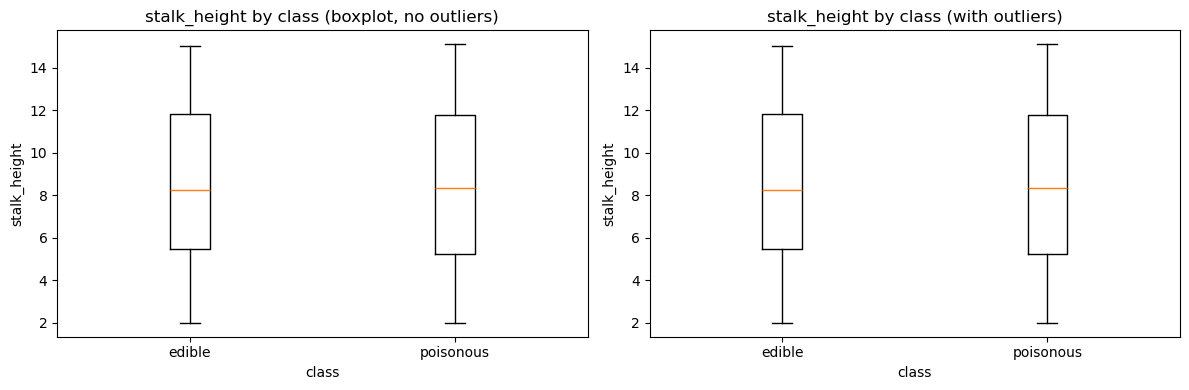

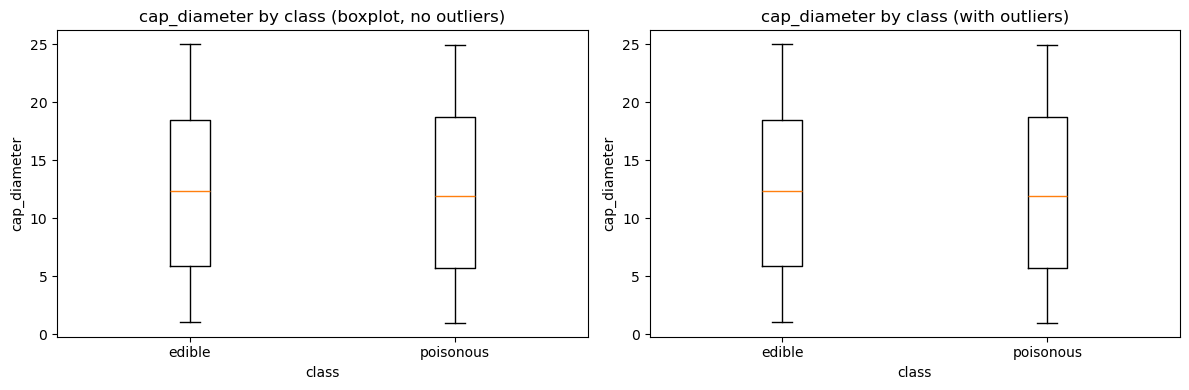

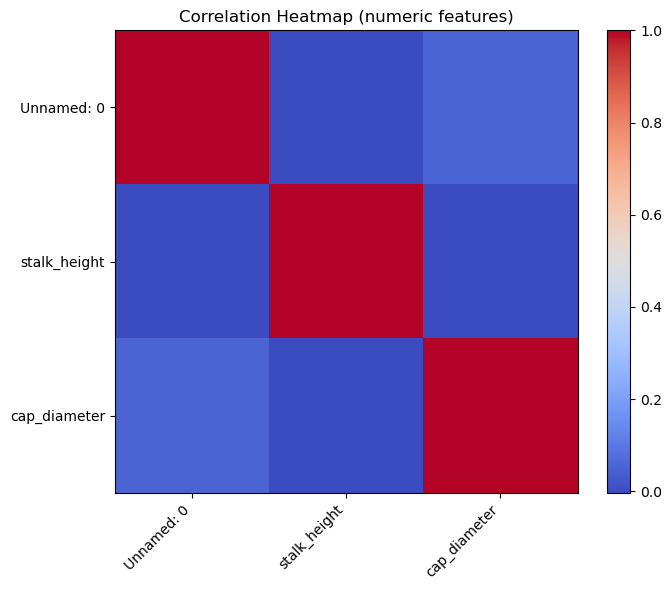

In [12]:
# ===== SVM ADD-ON: EDA distributions & correlations (Matplotlib 3.9-safe) =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# Assumes X, y, num_cols already defined

# Histograms for numeric
if num_cols:
    _ = X[num_cols].hist(figsize=(14, 8), bins=25)
    plt.suptitle("Numeric Feature Histograms", y=1.02)
    plt.show()

# Box/“violin-like” (second boxplot shows outliers) by class for top few numeric
if num_cols and pd.Series(y).nunique() <= 6:
    classes = sorted(pd.Series(y).astype(str).unique().tolist())
    for c in num_cols[:6]:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))

        # Prepare data per class
        data = [X.loc[pd.Series(y).astype(str) == cls, c].dropna().values for cls in classes]

        # Boxplot without outliers
        ax[0].boxplot(data, tick_labels=classes, showfliers=False)
        ax[0].set_title(f"{c} by class (boxplot, no outliers)")
        ax[0].set_xlabel("class"); ax[0].set_ylabel(c)

        # Boxplot with outliers (as a simple stand-in for violin)
        ax[1].boxplot(data, tick_labels=classes, showfliers=True)
        ax[1].set_title(f"{c} by class (with outliers)")
        ax[1].set_xlabel("class"); ax[1].set_ylabel(c)

        plt.tight_layout()
        plt.show()

# Correlation heatmap for numeric
if len(num_cols) >= 2:
    corr = X[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(8, 6))
    im = plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title("Correlation Heatmap (numeric features)")
    plt.tight_layout()
    plt.show()


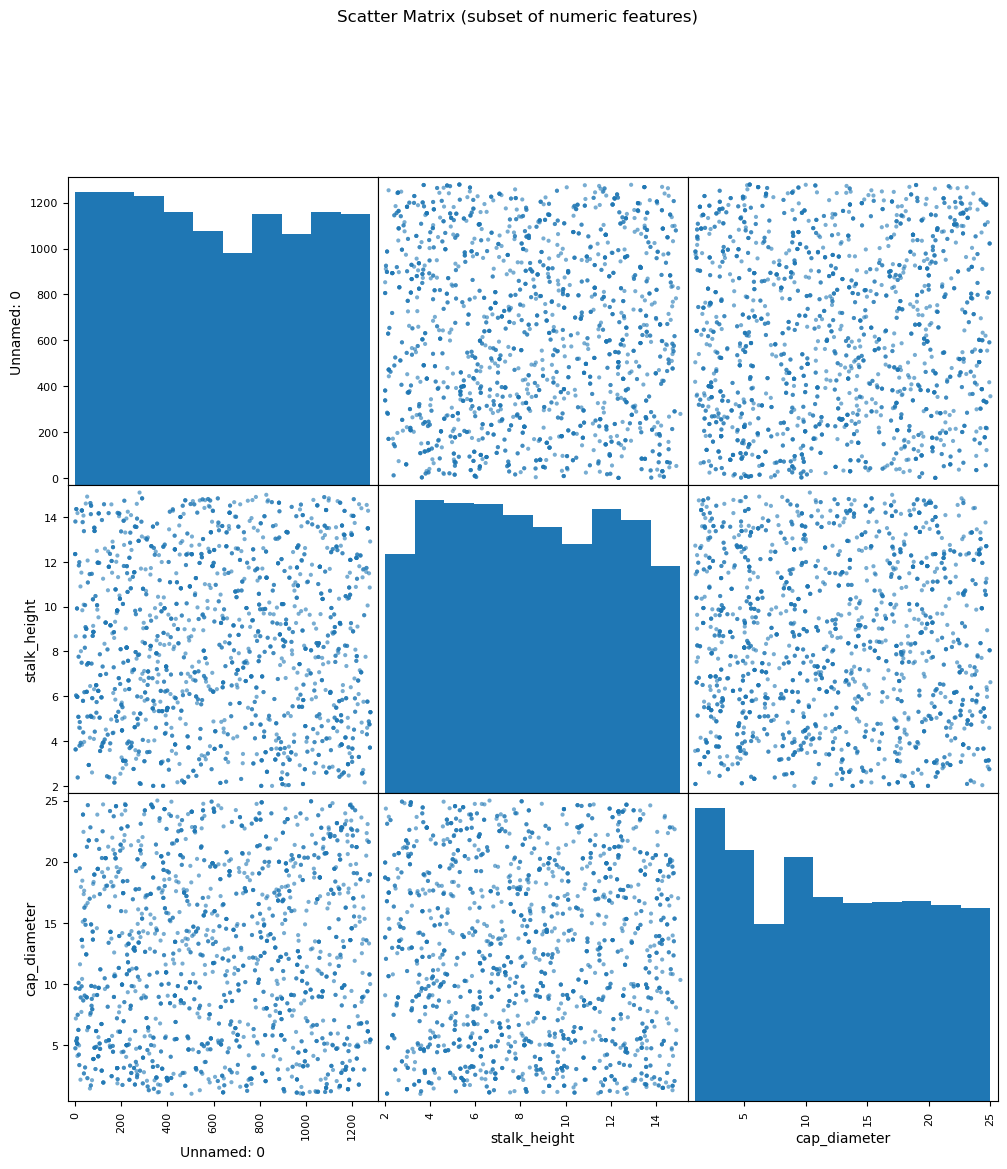

In [14]:
# ===== SVM ADD-ON: relationships (scatter matrix) =====
from pandas.plotting import scatter_matrix

# Use up to 6 numeric features to keep plot readable
sm_cols = num_cols[:6] if len(num_cols) > 6 else num_cols
if len(sm_cols) >= 2:
    scatter_matrix(X[sm_cols], figsize=(12, 12), diagonal='hist', alpha=0.6)
    plt.suptitle("Scatter Matrix (subset of numeric features)", y=1.02)
    plt.show()


In [18]:
# ===== SVM ADD-ON: preprocessing & split (fixed for sklearn ≥1.2) =====
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if y.nunique() <= 20 else None
)

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # ✅ fixed
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)


In [20]:
# ===== SVM ADD-ON: extended GridSearchCV =====
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm = SVC(probability=True)  # enables ROC-AUC later if needed

param_grid = [
    # RBF kernel
    {
        "clf__kernel": ["rbf"],
        "clf__C": [0.1, 1, 3, 10, 30, 100],
        "clf__gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1]
    },
    # Linear kernel
    {
        "clf__kernel": ["linear"],
        "clf__C": [0.1, 1, 3, 10, 30, 100]
    },
    # Polynomial kernel (degree sweep)
    {
        "clf__kernel": ["poly"],
        "clf__degree": [2, 3, 4],
        "clf__C": [0.1, 1, 10],
        "clf__gamma": ["scale", "auto"]
    }
]

pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", svm)
])

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",      # robust across class imbalance
    n_jobs=-1,
    cv=5,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV f1_macro:", grid.best_score_)
best_model = grid.best_estimator_


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best params: {'clf__C': 1, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}
Best CV f1_macro: 0.8021311567085355


=== Classification Report (Test) ===
              precision    recall  f1-score   support

      edible     0.9844    0.5250    0.6848       120
   poisonous     0.8304    0.9964    0.9058       280

    accuracy                         0.8550       400
   macro avg     0.9074    0.7607    0.7953       400
weighted avg     0.8766    0.8550    0.8395       400



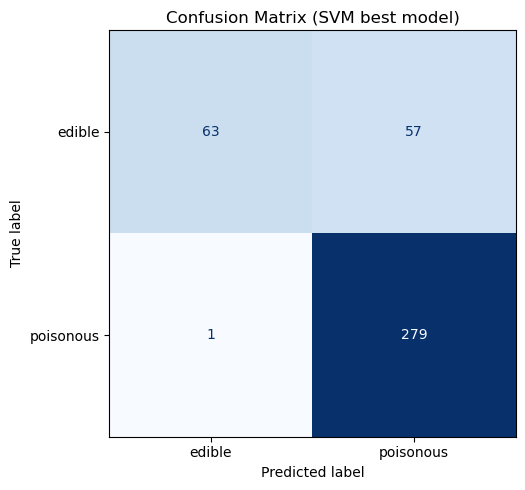

ROC-AUC (binary): 0.9448


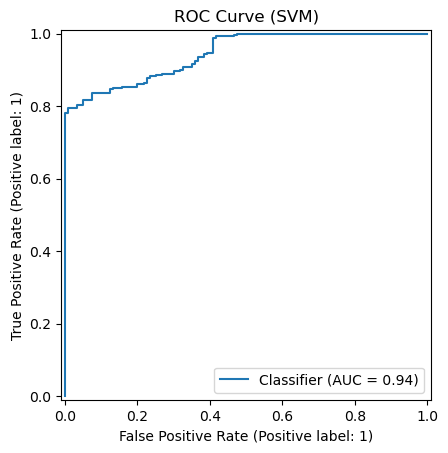

In [22]:
# ===== SVM ADD-ON: evaluation =====
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = best_model.predict(X_test)
print("=== Classification Report (Test) ===")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=sorted(y_test.unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_test.unique()))
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
plt.title("Confusion Matrix (SVM best model)")
plt.tight_layout()
plt.show()

# Optional ROC-AUC (binary only)
if y.nunique() == 2:
    from sklearn.metrics import roc_auc_score, RocCurveDisplay
    # map string labels to 0/1 consistently
    classes = sorted(y.unique())
    pos = classes[-1]  # treat lexicographically last as positive
    y_test_bin = (y_test == pos).astype(int)
    y_proba = best_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test_bin, y_proba)
    print(f"ROC-AUC (binary): {auc:.4f}")
    RocCurveDisplay.from_predictions(y_test_bin, y_proba)
    plt.title("ROC Curve (SVM)")
    plt.show()


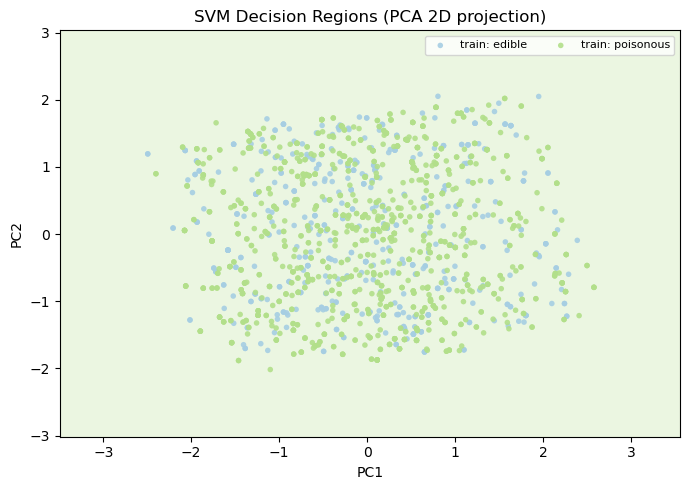

In [26]:
# ===== SVM ADD-ON: visual decision boundary via PCA (2D) — FIXED =====
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Fit prep-only on train and transform
prep_only = preprocessor.fit(X_train, y_train)
Xtr = prep_only.transform(X_train)
Xte = prep_only.transform(X_test)

# 2D projection
pca = PCA(n_components=2, random_state=42)
Ztr = pca.fit_transform(Xtr)
Zte = pca.transform(Xte)

# Pull best params if you ran GridSearchCV as 'grid'; else fallback
best = {}
try:
    best = grid.best_params_
except Exception:
    best = {}
    
svm2d = SVC(
    kernel=best.get("clf__kernel", "rbf"),
    C=best.get("clf__C", 1.0),
    gamma=best.get("clf__gamma", "scale"),
    degree=best.get("clf__degree", 3),
    random_state=42,
)
svm2d.fit(Ztr, y_train)

# Meshgrid over PCA space
h = 0.05
x_min, x_max = Ztr[:, 0].min() - 1, Ztr[:, 0].max() + 1
y_min, y_max = Ztr[:, 1].min() - 1, Ztr[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Zgrid = np.c_[xx.ravel(), yy.ravel()]
Zpred = svm2d.predict(Zgrid)  # 1-D labels for each grid point

# Map class labels -> integer indices (no pandas needed)
classes = sorted(pd.Series(y_train).astype(str).unique().tolist())
class_to_idx = {cls: i for i, cls in enumerate(classes)}
pred_idx = np.array([class_to_idx[c] for c in Zpred], dtype=int).reshape(xx.shape)

# Colors (repeat if more classes)
base_colors = ["#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f", "#cab2d6", "#ffff99", "#1f78b4", "#33a02c"]
colors = (base_colors * ((len(classes) // len(base_colors)) + 1))[:len(classes)]
region_cmap = ListedColormap(colors)

# Plot decision regions
plt.figure(figsize=(7, 5))
plt.contourf(xx, yy, pred_idx, alpha=0.25, cmap=region_cmap, levels=np.arange(len(classes)+1)-0.5)

# Overlay training points
for cls, col in zip(classes, colors):
    idx = (pd.Series(y_train).astype(str).values == cls)
    plt.scatter(Ztr[idx, 0], Ztr[idx, 1], s=16, c=col, label=f"train: {cls}", edgecolors="none", alpha=0.9)

plt.title("SVM Decision Regions (PCA 2D projection)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(loc="best", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()
